# Домашнее задание 1. Соревнование на Kaggle

## Выполнил: Зимаков Максим Александрович

## Задание:

В рамках данного учебного соревнования вам предстоит построить модель, классифицирующую изображения с одеждой, которая построена на датасете **Fashion-MNIST**.

> **Fashion-MNIST** — аналог знаменитого датасета MNIST, который состоит не из рукописных символов, а из предметов одежды. Он был создан, чтобы актуализировать учебные задачи в компьютерном зрении и приблизить их к реальности.

Решение более сложной постановки этой задачи может использоваться, например, в маркетплейсах. Покупателю могут рекомендоваться товары по изображениям в соответствии с введенным описанием. Продавцу при загрузке изображений в карточку товара могут автоматически рекомендоваться теги и описание предмета одежды.

Каждое изображение представляет собой набор из 784 пикселей (28x28). Каждый пиксель принимает значение от 0 до 255, обозначая его цвет в черно-белой шкале. Обучающая выборка содержит 786 столбцов, где первый (label) — принадлежность изображения к классу, а последний — его уникальный номер (id). Остальные столбцы — пиксели изображения.

Проведите первичный анализ данных, чтобы определить наличие NaN значений.

Тестовая выборка, на основе которой должно быть получено исследование, содержит все те же столбцы, кроме ```label```.

Расшифровка классов (```label```), к которым принадлежат изображения:

0. ```T-shirt/top``` — футболка;
1. ```Trouser``` — брюки;
2. ```Pullover``` — свитер;
3. ```Dress``` — платье;
4. ```Coat``` — пальто;
5. ```Sandal``` — сандалия;
6. ```Shirt``` — рубашка;
7. ```Sneaker``` — кроссовок;
8. ```Bag``` — сумка;
9. ```Ankle boot``` — сапог.

Структура данных:

* ```fmnist_train.csv``` — обучающая выборка;
* ```fmnist_test.csv``` — тестовая выборка (на которой должно быть получено предсказание);
* ```sample_submission.csv``` — пример решения.

Исходная публикация датасета

Задача будет считаться решенной, если в Public Leaderboard вы наберете ```score```, который будет равен 0.80 или больше. В качестве метрики используется ```accuracy```. В день вы можете отправлять не более 20 решений (это ограничения платформы). Помните, что решения принимаются только в том формате, который представлен в файле ```sample_submission.csv```.

## Выполнение:

In [15]:
# Импортьирует библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Загрузка данных

In [17]:
# Загружаем данные для обучения
train_df = pd.read_csv('data/fmnist_train.csv', sep = ',')
train_df.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0,2


In [18]:
# Загружаем данные для тетсирования
test_df = pd.read_csv('data/fmnist_test.csv', sep = ',')
test_df.head(3)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,0,0,0,0,0,0,0,9,8,0,...,87,56,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,63,53,31,0,0,0,2


In [19]:
# Загружаем данные с примером результата
sample_submission = pd.read_csv('data/sample_submission.csv', sep = ',')
sample_submission.head(3)

,Id,label
0,0,0
1,1,0
2,2,0


### Проверка на наличие NaN

In [21]:
print(f"NaN в обучающих данных: {train_df.isnull().sum().sum()}")

NaN в обучающих данных: 424


In [22]:
print(f"NaN в тестовых  данных: {test_df.isnull().sum().sum()}")

NaN в тестовых  данных: 0


#### Обработка Nan

In [24]:
# Смотрим на распределение NaN по столбцам
nan_columns = train_df.isnull().sum(axis = 0)
print("Распределение NaN по столбцам:\n", nan_columns[nan_columns > 0])

Распределение NaN по столбцам:
 pixel361    1
pixel362    1
pixel363    1
pixel364    1
pixel365    1
           ..
pixel780    1
pixel781    1
pixel782    1
pixel783    1
pixel784    1
Length: 424, dtype: int64


In [25]:
# Смотрим на распределение NaN по строкам
nan_s = train_df.isnull().sum(axis = 1)
print("Распределение NaN по строкам:\n", nan_s[nan_s > 0])

Распределение NaN по строкам:
 17039    424
dtype: int64


##### Вариант удаление пропусков

In [27]:
# Удалим строки с NaN
train_df_cleaned = train_df.dropna(axis=0, how='any')

# Проверим новый размер данных
print(f"Удалено строк: {len(train_df) - len(train_df_cleaned)}")

Удалено строк: 1


##### Вариант обработки пропусков

In [29]:
# Заполним NaN медианным значением пикселя
pixel_columns = [col for col in train_df.columns if 'pixel' in col]
train_df_filled = train_df.copy()
train_df_filled[pixel_columns] = train_df[pixel_columns].fillna(
    train_df[pixel_columns].median()
)

In [30]:
# Убедимся, что NaN устранены
assert train_df_cleaned.isna().sum().sum() == 0  # Для варианта с удалением
assert train_df_filled.isna().sum().sum() == 0  # Для варианта с заполнением

### Строим функицю предобработки

In [32]:
# Строим функицю предобработки
def preprocess_data(df, is_train=True):
    df = df.dropna(axis=0, how='any').reset_index(drop=True)

    if is_train:
        y = df['label'].values
        df = df.drop(columns=['label', 'Id']) 
    else:
        y = None
        df = df.drop(columns=['Id'])

    X = df.values.astype('float32') / 255.0
    X = X.reshape(-1, 28, 28, 1)

    return X, y

### Визуализируем данные

In [34]:
# Пишем функцию для визуализации данныхх из датасета
def visualize_fashionmnist(data, num_images=10, labels_map=None, figsize=(12, 12), 
                          random_seed=None, start_index=0):
    """
    Визуализирует изображения из датасета Fashion-MNIST
    
    Args:
        data (DataFrame): Датафрейм с данными
        num_images (int): Количество изображений для отображения (макс. 25)
        labels_map (dict): Словарь соответствия меток классов и названий
        figsize (tuple): Размер фигуры
        random_seed (int): Seed для воспроизводимости случайного выбора
        start_index (int): Начальный индекс для выбора изображений (если не используется случайный выбор)
    """
    
    if labels_map is None:
        labels_map = {
            0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress",
            4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
        }

    # Ограничиваем максимальное количество изображений
    num_images = min(num_images, 25)

    # Создаем сетку для отображения
    rows = int(np.ceil(num_images / 5))
    cols = min(num_images, 5)

    plt.figure(figsize=figsize)

    # Выбираем случайные или последовательные индексы
    if random_seed is not None:
        np.random.seed(random_seed)
        indices = np.random.choice(len(data), num_images, replace=False)
    else:
        indices = range(start_index, start_index + num_images)

    for i, idx in enumerate(indices):
        if 'label' in data.columns:
            label = data.iloc[idx]['label']
            pixels = data.iloc[idx].drop(['label', 'Id']).values
        else:
            label = "Unknown"
            pixels = data.iloc[idx].drop(['Id']).values

        # Преобразуем в изображение
        img = pixels.reshape(28, 28).astype(np.uint8)

        # Создаем subplot
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Class: {label}\n{labels_map.get(label, 'Unknown')}", fontsize=9)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

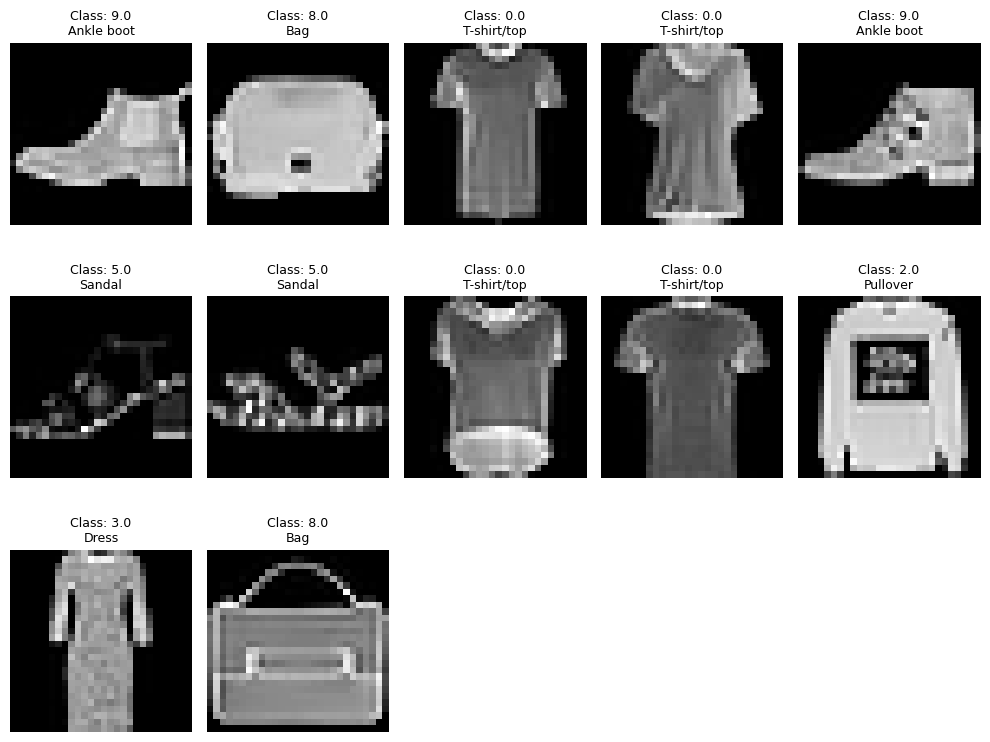

In [35]:
# Для обучающих данных с метками
visualize_fashionmnist(
    data=train_df,
    num_images=12,
    random_seed=42,
    figsize=(10, 8)
)

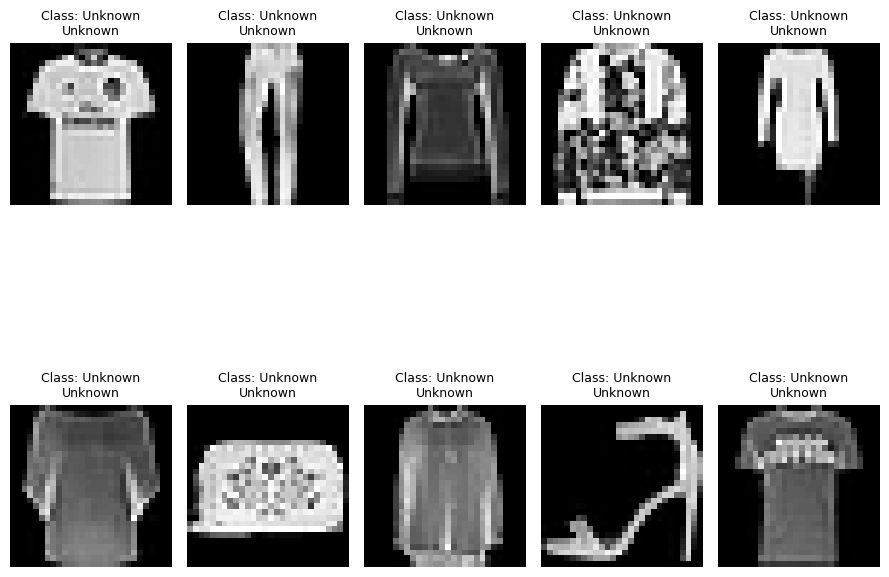

In [36]:
# Для тестовых данных без меток
visualize_fashionmnist(
    data=test_df,
    num_images=10,
    figsize=(9, 9)
)

### Предобработка и разделение

In [38]:
# Предобработка данных
X_train, y_train = preprocess_data(train_df)
X_test, _ = preprocess_data(test_df, is_train=False)

# Разделение на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Разработка модели

In [40]:
# Строим модель
model = keras.Sequential([
    # Conv + Maxpooling + Dropout
    layers.Conv2D(32, (4,4), padding='same', activation='relu', input_shape=(28,28,1)),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),

    # Conv + Maxpooling + Dropout
    layers.Conv2D(64, (4,4), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    
    # layers.Conv2D(128, (3,3), activation='relu'),
    # layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    # layers.Dropout(0.5),

    layers.Dense(10, activation='softmax')
])

In [41]:
# def residual_block(x, filters_in, filters_out):
#     # Добавляем свертку 1x1 в shortcut при изменении количества фильтров
#     shortcut = x
#     if filters_in != filters_out:
#         shortcut = layers.Conv2D(filters_out, (1,1), padding='same')(shortcut)
#         shortcut = layers.BatchNormalization()(shortcut)
    
#     # Основной путь
#     x = layers.Conv2D(filters_out, (3,3), padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.Conv2D(filters_out, (3,3), padding='same')(x)
#     x = layers.BatchNormalization()(x)
    
#     # Сложение с shortcut
#     x = layers.Add()([shortcut, x])
#     x = layers.Activation('relu')(x)
#     return x

# # Полная архитектура с исправленными residual блоками
# inputs = keras.Input(shape=(28,28,1))
# x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
# x = layers.MaxPooling2D((2,2))(x)  # Размер 13x13

# x = residual_block(x, filters_in=32, filters_out=32)  # Сохраняем размерность
# x = layers.MaxPooling2D((2,2))(x)  # Размер 6x6

# x = residual_block(x, filters_in=32, filters_out=64)  # Изменяем фильтры через shortcut
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(128, activation='relu')(x)
# outputs = layers.Dense(10, activation='softmax')(x)

# model = keras.Model(inputs=inputs, outputs=outputs)

In [42]:
# Определяем оптимайзер для модеил
optimizer = Adam()

In [43]:
# Компилируем модель
model.compile(
    # optimizer = "adam",
    optimizer = optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
# Выводим сводное представление модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        544       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)          0

In [45]:
# Первичное обучение модели
history_1 = model.fit(
    X_train, 
    y_train,
    validation_data = (X_val, y_val),
    epochs = 20,
    batch_size = 256,
    verbose = 1,
)

Epoch 1/20


54/54 [==============================] - 5s 60ms/step - loss: 1.0067 - accuracy: 0.6472 - val_loss: 1.7239 - val_accuracy: 0.6382
Epoch 2/20
54/54 [==============================] - 3s 54ms/step - loss: 0.5419 - accuracy: 0.8062 - val_loss: 1.5844 - val_accuracy: 0.5895
Epoch 3/20
54/54 [==============================] - 3s 54ms/step - loss: 0.4523 - accuracy: 0.8395 - val_loss: 1.3558 - val_accuracy: 0.7142
Epoch 4/20
54/54 [==============================] - 3s 53ms/step - loss: 0.3957 - accuracy: 0.8583 - val_loss: 1.1363 - val_accuracy: 0.7923
Epoch 5/20
54/54 [==============================] - 3s 62ms/step - loss: 0.3629 - accuracy: 0.8709 - val_loss: 0.8971 - val_accuracy: 0.8169
Epoch 6/20
54/54 [==============================] - 3s 57ms/step - loss: 0.3466 - accuracy: 0.8765 - val_loss: 0.6972 - val_accuracy: 0.8706
Epoch 7/20
54/54 [==============================] - 3s 59ms/step - loss: 0.3248 - accuracy: 0.8825 - val_loss: 0.5139 - val_accuracy: 0.8630
Epoch 8/20


In [46]:
# Подготовка для аугментауии
datagen = ImageDataGenerator(
    rotation_range=15,      # Поворот
    width_shift_range=0.15, # Сдвиг по ширине 
    height_shift_range=0.15,# Сдвиг по высоте 
    zoom_range=0.15,        # Зум 
    horizontal_flip=True,   # Горизонтальное отражение
    fill_mode='nearest'     # Заполнение пикселей при трансформациях
)

In [47]:
# Подгтовка аугментированнх данных для обучения
batch_size = 128

# Для обучающих данных
train_generator = datagen.flow(
    X_train, 
    y_train,
    batch_size=batch_size,
    shuffle=True
)

# Для валидационных данных (без аугментации)
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(
    X_val,
    y_val,
    batch_size=batch_size,
    shuffle=False
)

In [55]:
# Доп. обучение модели на аугментированных данных
history_2 = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size, 
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size,
    verbose=1
)

Epoch 1/10
106/106 [==============================] - 6s 46ms/step - loss: 0.9334 - accuracy: 0.6751 - val_loss: 0.4371 - val_accuracy: 0.8398
Epoch 2/10
106/106 [==============================] - 5s 47ms/step - loss: 0.6952 - accuracy: 0.7422 - val_loss: 0.3942 - val_accuracy: 0.8498
Epoch 3/10
106/106 [==============================] - 5s 43ms/step - loss: 0.6413 - accuracy: 0.7611 - val_loss: 0.4092 - val_accuracy: 0.8425
Epoch 4/10
106/106 [==============================] - 5s 44ms/step - loss: 0.6048 - accuracy: 0.7709 - val_loss: 0.4425 - val_accuracy: 0.8374
Epoch 5/10
106/106 [==============================] - 5s 44ms/step - loss: 0.5798 - accuracy: 0.7833 - val_loss: 0.3981 - val_accuracy: 0.8489
Epoch 6/10
106/106 [==============================] - 5s 44ms/step - loss: 0.5630 - accuracy: 0.7891 - val_loss: 0.3764 - val_accuracy: 0.8519
Epoch 7/10
106/106 [==============================] - 5s 45ms/step - loss: 0.5615 - accuracy: 0.7915 - val_loss: 0.3903 - val_accuracy: 0.8510

In [56]:
# Окончатлеьно обучение модели
history_3 = model.fit(
    X_train, 
    y_train,
    validation_data = (X_val, y_val),
    epochs = 30,
    batch_size = 128,
    verbose = 1,
)

Epoch 1/30
107/107 [==============================] - 4s 36ms/step - loss: 0.3325 - accuracy: 0.8768 - val_loss: 0.2982 - val_accuracy: 0.8888
Epoch 2/30
107/107 [==============================] - 3s 30ms/step - loss: 0.2758 - accuracy: 0.8974 - val_loss: 0.2933 - val_accuracy: 0.8894
Epoch 3/30
107/107 [==============================] - 3s 30ms/step - loss: 0.2557 - accuracy: 0.9054 - val_loss: 0.2804 - val_accuracy: 0.8929
Epoch 4/30
107/107 [==============================] - 3s 29ms/step - loss: 0.2326 - accuracy: 0.9116 - val_loss: 0.2731 - val_accuracy: 0.8999
Epoch 5/30
107/107 [==============================] - 3s 30ms/step - loss: 0.2273 - accuracy: 0.9162 - val_loss: 0.2729 - val_accuracy: 0.9008
Epoch 6/30
107/107 [==============================] - 3s 30ms/step - loss: 0.2088 - accuracy: 0.9221 - val_loss: 0.2623 - val_accuracy: 0.9070
Epoch 7/30
107/107 [==============================] - 3s 32ms/step - loss: 0.2005 - accuracy: 0.9247 - val_loss: 0.2902 - val_accuracy: 0.8929

In [57]:
# Предсказание на тестовых данных
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

313/313 [==============================] - 1s 3ms/step


### Выгрузка результата

In [58]:
# Создание DataFrame с предсказаниями
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'label': predicted_labels,
})

In [59]:
# Проверка первых строк
print(submission.head(3))

   Id  label
0   0      0
1   1      1
2   2      2


In [60]:
# Сохранение результатов
submission.to_csv('submission.csv', index = False)